<a href="https://colab.research.google.com/github/deepakgarg08/llm-diary/blob/main/llm_chronicles_rnn_encoder_decoder_translation_w_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Language Translation with RNN and Attention

In this notebook, we implement a Recurrent Neural Network (RNN) with attention for language translation, following the approach described in *Neural Machine Translation by Jointly Learning to Align and Translate* by **Dzmitry Bahdanau** et al. The focus is on building and understanding the attention mechanism integral to enhancing the translation quality.

For further details, refer to the original paper here: https://arxiv.org/abs/1409.0473.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

In [ ]:
# Device-independent code
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=0)

# 1 - Processing dataset

This section is identical to our previous RNN for translation, refer to that notebook for more details:

https://colab.research.google.com/drive/1GBC7eLlEM-HqKLUuMcFIQdVuYXzLoS_P?usp=sharing

In [ ]:
!wget https://raw.githubusercontent.com/kyuz0/llm-chronicles/main/datasets/eng_ita_v2.txt

--2023-12-19 17:49:42--  https://raw.githubusercontent.com/kyuz0/llm-chronicles/main/datasets/eng_ita_v2.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7240475 (6.9M) [text/plain]
Saving to: ‘eng_ita_v2.txt’

eng_ita_v2.txt      100%[===================>]   6.90M  --.-KB/s    in 0.1s    

2023-12-19 17:49:42 (53.6 MB/s) - ‘eng_ita_v2.txt’ saved [7240475/7240475]



In [ ]:
import numpy as np

# Function to read the file and extract pairs
def read_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.read().strip().split('\n')
    pairs = [[s for s in line.split(' -> ')] for line in lines]
    return pairs

def tokenize(sentence):
  return sentence.lower().split()

# Tokenize and build vocabularies
def build_vocab(pairs):
    eng_vocab = set()
    ita_vocab = set()
    for eng, ita in pairs:
        eng_vocab.update(tokenize(eng))
        ita_vocab.update(tokenize(ita))
    return eng_vocab, ita_vocab

In [ ]:
# Path to your text file
file_path = 'eng_ita_v2.txt'

# Process the data
pairs = read_data(file_path)
english_vocab, italian_vocab = build_vocab(pairs)

# Creating word to integer mapping
eng_word2int = {word: i for i, word in enumerate(english_vocab)}
ita_word2int = {word: i for i, word in enumerate(italian_vocab)}

# Creating integer to word mapping
eng_int2word = {i: word for word, i in eng_word2int.items()}
ita_int2word = {i: word for word, i in ita_word2int.items()}

print('English vocabulary size:', len(english_vocab))
print('Italian vocabulary size:', len(italian_vocab))

English vocabulary size: 4997
Italian vocabulary size: 13673


In [ ]:
# Example usage
eng_example = "Who are you"
ita_example = "chi sei tu"

# Encoding
eng_encoded = np.array([eng_word2int[word] for word in tokenize(eng_example)], dtype=np.int32)
ita_encoded = np.array([ita_word2int[word] for word in tokenize(ita_example)], dtype=np.int32)

print('English text encoded:', eng_encoded)
print('Italian text encoded:', ita_encoded)

# Decoding
print('Decoded English:', ' '.join([eng_int2word[i] for i in eng_encoded]))
print('Decoded Italian:', ' '.join([ita_int2word[i] for i in ita_encoded]))

English text encoded: [2880 1092 1206]
Italian text encoded: [6553 5124 4637]
Decoded English: who are you
Decoded Italian: chi sei tu


## 1.1 - Dataset and Dataloader

In [ ]:
# Special tokens
PAD_TOKEN = "<PAD>"
EOS_TOKEN = "<EOS>"
SOS_TOKEN = "<SOS>"
UNK_TOKEN = "<UNK>"

# Update the function to create mappings to include the SOS token
def create_mappings(vocab):
    vocab = [PAD_TOKEN, SOS_TOKEN, EOS_TOKEN, UNK_TOKEN] + sorted(vocab)
    word2int = {word: i for i, word in enumerate(vocab)}
    int2word = {i: word for word, i in word2int.items()}
    return word2int, int2word

# Update the vocabularies
eng_word2int, eng_int2word = create_mappings(english_vocab)
ita_word2int, ita_int2word = create_mappings(italian_vocab)

In [ ]:
class TranslationDataset(Dataset):
    def __init__(self, pairs, eng_word2int, ita_word2int):
        self.pairs = pairs
        self.eng_word2int = eng_word2int
        self.ita_word2int = ita_word2int

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        eng, ita = self.pairs[idx]
        eng_tensor = torch.tensor([self.eng_word2int[word] for word in tokenize(eng)] + [self.eng_word2int[EOS_TOKEN]], dtype=torch.long)
        ita_tensor = torch.tensor([self.ita_word2int[word] for word in tokenize(ita)] + [self.ita_word2int[EOS_TOKEN]], dtype=torch.long)
        return eng_tensor, ita_tensor

# Custom collate function to handle padding
def collate_fn(batch):
    eng_batch, ita_batch = zip(*batch)
    eng_batch_padded = pad_sequence(eng_batch, batch_first=True, padding_value=eng_word2int[PAD_TOKEN])
    ita_batch_padded = pad_sequence(ita_batch, batch_first=True, padding_value=ita_word2int[PAD_TOKEN])
    return eng_batch_padded, ita_batch_padded

In [ ]:
from torch.nn.utils.rnn import pad_sequence

# Create the dataset and DataLoader
translation_dataset = TranslationDataset(pairs, eng_word2int, ita_word2int)
batch_size = 64
translation_dataloader = DataLoader(translation_dataset, batch_size=batch_size, shuffle=True,  drop_last=True, collate_fn=collate_fn)

print("Translation samples: ", len(translation_dataset))
print("Translation batches: ", len(translation_dataloader))

Translation samples:  120746
Translation batches:  1886


In [ ]:
# Example: iterating over the DataLoader
for eng, ita in translation_dataloader:
    print("English batch:", eng)
    print("Italian batch:", ita)
    break # remove this to iterate over the whole dataset

English batch: tensor([[4478, 1314, 1360, 2781,    2,    0,    0,    0,    0,    0],
        [4480, 3123, 1979,  741,    2,    0,    0,    0,    0,    0],
        [4808, 2090, 4478, 1314, 1305, 4389,    2,    0,    0,    0],
        [4478, 1979,  422, 1537,    2,    0,    0,    0,    0,    0],
        [4478, 3765, 4467,  402,  316,    2,    0,    0,    0,    0],
        [4478, 1979, 2590,   37, 3789, 2731,    2,    0,    0,    0],
        [2149, 1860, 4467, 2799, 4624, 4423, 4828,    2,    0,    0],
        [ 654, 4985, 4344, 2652, 4874, 4478, 2306, 2031,    2,    0],
        [3892, 2306, 2308,    2,    0,    0,    0,    0,    0,    0],
        [2146, 4777, 4467, 1853, 4467, 4392, 2421,    2,    0,    0],
        [4993, 1315, 2303, 2031,    2,    0,    0,    0,    0,    0],
        [2525, 4467, 4993, 1620,    2,    0,    0,    0,    0,    0],
        [1305, 4985, 4776, 2652, 4467, 1562, 2308, 4467, 4985,    2],
        [4344, 4478, 4467,  879, 2076,    2,    0,    0,    0,    0],
     

# 2 - Encoder / Decoder RNN with Attention


In this cell, we introduce SimpleAttention, a class implementing a basic form of attention mechanism inspired by the Bahdanau et al. paper. This attention mechanism computes a **context vector** by focusing on different parts of the input sequence when predicting each word of the output sequence.


![picture](https://raw.githubusercontent.com/kyuz0/llm-chronicles/main/4.8%20-%20Lab%20-%20Attention/attention_v1.png)

The formula for Bahdanau attention is as follows:

$\text{Attention}(d_{i-1}, h_s) = v^T \tanh(W_{attn}[d_{i-1}; h_s])
$

- $h_{s}$: all the encoder hidden states
- $d_{i-1}$: hidden state of the decoder
- $W_{attn}$ , $v$: learnable weights of the attention mechanism
- $;$: concatenation

In our implementation, SimpleAttention uses linear layers to compute the attention weights, and then these weights are used to create a context vector from the encoder outputs.

In [ ]:
class SimpleAttention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.attn = nn.Linear(hidden_size * 2, hidden_size * 2, bias=False)
        self.v = nn.Linear(hidden_size * 2, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden: [layer*D num, batch size, hidden size]
        # encoder_outputs: [batch size, sequence length, hidden size]

        # we only have 1 layer and 1 direction in the decoder RNN, drop this dimension
        hidden = hidden.squeeze(0)  # [batch size, hidden size]

        # Repeat decoder hidden state across the sequence length
        hidden = hidden.unsqueeze(1).repeat(1, encoder_outputs.size(1), 1)

        # Concatenate the hidden state with encoder outputs
        combined = torch.cat((hidden, encoder_outputs), dim=2)

        # Compute the attention scores
        x = torch.tanh(self.attn(combined))
        attention = self.v(x).squeeze(2)
        attention_weights = F.softmax(attention, dim=1)

        # Compute the context as weighted sum of encoder outputs
        context_vector = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs).squeeze(1)

        return context_vector, attention_weights

## 2.1 - Adding Attention and Context to the Decoder

This cell defines the Decoder class, integrating the previously implemented SimpleAttention mechanism into the decoding process. The Decoder takes encoded inputs and applies attention to focus on relevant parts of the input sequence for each step in the decoding phase. Key components include:

- **Embedding Layer**: Maps input tokens to embeddings.

- **Attention Integration**: Utilizes SimpleAttention to generate a context vector by weighting encoder outputs based on the current hidden state.

- **LSTM Layer**: Processes the concatenated embedding and context vector.

- **Fully Connected Layer**: Transforms LSTM outputs to vocabulary-sized vectors for token prediction.

- **Attention Visualization**: Optionally stores attention weights for later analysis.

The **forward** method performs these steps, embedding the input, calculating the context vector using attention, concatenating it with the embedding, and then passing this through the LSTM and fully connected layer for output generation. This approach enables the decoder to dynamically focus on different parts of the input sequence, enhancing translation accuracy.

![picture](https://raw.githubusercontent.com/kyuz0/llm-chronicles/main/4.8%20-%20Lab%20-%20Attention/encoder_decoder_context.png)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers=num_layers,
                            batch_first=True, bidirectional=True)

    def forward(self, x):
        embedded = self.embedding(x)
        outputs, (hidden, cell) = self.lstm(embedded)

        # concatenate hidden states of the bi-directional RNN layer
        hidden = torch.cat((hidden[0,:,:], hidden[1,:,:]), dim=1).unsqueeze(0)
        cell = torch.cat((cell[0,:,:], cell[1,:,:]), dim=1).unsqueeze(0)

        return outputs, hidden, cell

class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.attention = SimpleAttention(hidden_size)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(hidden_size + embed_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.attention_matrix = []

    def forward(self, x, hidden, cell, encoder_outputs, store_attention=False):
        x = self.embedding(x)
        context_vector, attention_weights = self.attention(hidden, encoder_outputs)

        if store_attention:
          # Store attention weights for visualization
          self.attention_matrix.append(attention_weights.detach().cpu().numpy())

        lstm_input = torch.cat((x, context_vector.unsqueeze(1)), dim=2)

        out, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))
        out = self.fc(out).reshape(out.size(0), -1)
        return out, hidden, cell

    def reset_attention_matrix(self):
        self.attention_matrix = []

## 2.2 - Instantiate the models

In [ ]:
# Hyperparameters
eng_vocab_size = len(eng_word2int)
ita_vocab_size = len(ita_word2int)
embed_size = 256
hidden_size = 512
num_layers = 1

# Initialize the models
encoder = Encoder(eng_vocab_size, embed_size, hidden_size, num_layers).to(DEVICE)
decoder = Decoder(ita_vocab_size, embed_size, hidden_size*2, num_layers).to(DEVICE)

# 3 - Translation (inference)

This cell updates the translate method to incorporate the attention mechanism into the translation process, contrasting with the previous approach where only the encoder hidden state was passed to the decoder.

Key differences are:

- **Encoder Outputs Utilization**: In addition to the encoder's hidden and cell states, the new method now also captures and passes the full sequence of encoder outputs to the decoder. This is crucial for computing the context vector at each decoding step.

- **Attention Visualization**: The decoder's reset_attention_matrix method is called before the decoding loop starts, and the store_attention flag is set to True in the decoder call to record attention weights for each step, enabling later visualization and analysis.

In [ ]:
def translate(encoder, decoder, sentence, eng_word2int, ita_int2word, max_length=15):
    encoder.eval()
    decoder.eval()
    with torch.inference_mode():
        # Tokenize and encode the sentence
        input_tensor = torch.tensor([eng_word2int[word] for word in tokenize(sentence)]
                                    + [eng_word2int[EOS_TOKEN]], dtype=torch.long)
        input_tensor = input_tensor.view(1, -1).to(DEVICE)  # batch_first=True

        # Pass the input through the encoder
        encoder_outputs, encoder_hidden, encoder_cell = encoder(input_tensor)
        # Initialize the decoder input with the SOS token
        decoder_input = torch.tensor([[eng_word2int[SOS_TOKEN]]], dtype=torch.long)  # SOS
        # Initialize the hidden state of the decoder with the encoder's hidden state
        decoder_hidden, decoder_cell = encoder_hidden, encoder_cell

        decoder.reset_attention_matrix()
        # Decoding the sentence
        decoded_words = []
        last_word = torch.tensor([[eng_word2int[SOS_TOKEN]]]).to(DEVICE)
        for di in range(max_length):
            logits, decoder_hidden, decoder_cell = decoder(last_word, decoder_hidden,
                                  decoder_cell, encoder_outputs, store_attention=True)
            next_token = logits.argmax(dim=1) # greedy
            last_word = torch.tensor([[next_token]]).to(DEVICE)
            if next_token.item() == ita_word2int[EOS_TOKEN]:
                break
            else:
                decoded_words.append(ita_int2word.get(next_token.item()))

        return ' '.join(decoded_words)

In [ ]:
# Example usage
# s/he likes music, listening to music,
# tom likes hot chocolate
# i want to go home now
# tom likes chocolate
# tom was right about that
# tom said he would not come
# this is a fun game

sentence = "tom likes hot chocolate"
translated_sentence = translate(encoder, decoder, sentence, eng_word2int, ita_int2word)
print("Translated:", translated_sentence)

Translated: a tom piace la cioccolata calda


#3 - Training

In the training loop, the core process remains the same. The only modification is that we now retain the encoder outputs and pass them to the decoder for effective context calculation during each decoding step.

In [ ]:
import torch.optim as optim
import torch.nn as nn
import random

# Loss Function (exclude padding)
loss_fn = nn.CrossEntropyLoss(ignore_index=eng_word2int[PAD_TOKEN])

# Optimizers
encoder_optimizer = torch.optim.AdamW(encoder.parameters())
decoder_optimizer = torch.optim.AdamW(decoder.parameters())

# Number of epochs
num_epochs = 10

# Training Loop
encoder.train()
decoder.train()

for epoch in range(num_epochs):
    for i, (input_tensor, target_tensor) in enumerate(translation_dataloader):
        input_tensor, target_tensor = input_tensor.to(DEVICE), target_tensor.to(DEVICE)

        # Zero gradients of both optimizers
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        target_length = target_tensor.size(1)

        # Encoder
        encoder_output, encoder_hidden, encoder_cell = encoder(input_tensor)

        # Decoder
        decoder_input = torch.full((batch_size, 1), eng_word2int[SOS_TOKEN], dtype=torch.long).to(DEVICE)
        decoder_hidden = encoder_hidden
        decoder_cell = encoder_cell

        # Randomly select a word index from the target sequence
        random_word_index = random.randint(0, target_length - 1)

        loss = 0

        for di in range(target_length):
            logits, decoder_hidden, decoder_cell  = decoder(decoder_input, decoder_hidden, decoder_cell, encoder_output)
            #if di == random_word_index:
            #    loss = loss_fn(logits, target_tensor[:, di])
            #    break  # Only compute loss for the randomly selected word
            loss += loss_fn(logits, target_tensor[:,di])
            decoder_input = target_tensor[:, di].reshape(batch_size, 1)  # Teacher forcing

        # Backpropagation
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(encoder.parameters(), 2)
        #torch.nn.utils.clip_grad_norm_(decoder.parameters(), 2)

        encoder_optimizer.step()
        decoder_optimizer.step()

        if i % 100 == 0:  # Print loss every 10 batches
            print(f'Epoch {epoch}, Batch {i}, Loss: {loss.item() / target_length:.4f}')


# 4 - Saving / Loading Models

In [ ]:
# Save model
torch.save(encoder.state_dict(), "encoder.pth")
torch.save(decoder.state_dict(), "decoder.pth")

In [ ]:
# Download model
!pip install --upgrade --no-cache-dir gdown
!gdown --id "15WbJ43paruf0iDZnV4HoxjwoFuyc3ccF"
!gdown --id "15bhCm79_MiILlTVnXUL6tqEQgjaf3nHc"


/usr/local/lib/python3.10/dist-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=15WbJ43paruf0iDZnV4HoxjwoFuyc3ccF
To: /content/encoder.pth
100% 17.7M/17.7M [00:00<00:00, 74.4MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=15bhCm79_MiILlTVnXUL6tqEQgjaf3nHc
From (redirected): https://drive.google.com/uc?id=15bhCm79_MiILlTVnXUL6tqEQgjaf3nHc&confirm=t&uuid=f9f49066-06b4-433e-88ca-e9c33cbf351e
To: /content/decoder.pth
100% 125M/125M [00:01<00:00, 75.8MB/s]


In [ ]:
# Load model

encoder.load_state_dict(torch.load("encoder.pth"))
decoder.load_state_dict(torch.load("decoder.pth"))

<All keys matched successfully>

# 5 - Visualize Attention Matrix

This cell visualizes the attention matrix, offering insights into how the model focuses on different parts of the input sentence when predicting each word in the output.

- The plot_attention function creates a heatmap using Matplotlib and Seaborn, with the attention weights displayed for each input-output word pair.

- The x-axis labels represent words from the input sentence, and the y-axis labels correspond to words in the output sentence.

By examining this heatmap, we can understand the alignment and focus patterns of the model during translation, providing a clear and interpretable view of the attention mechanism at work.

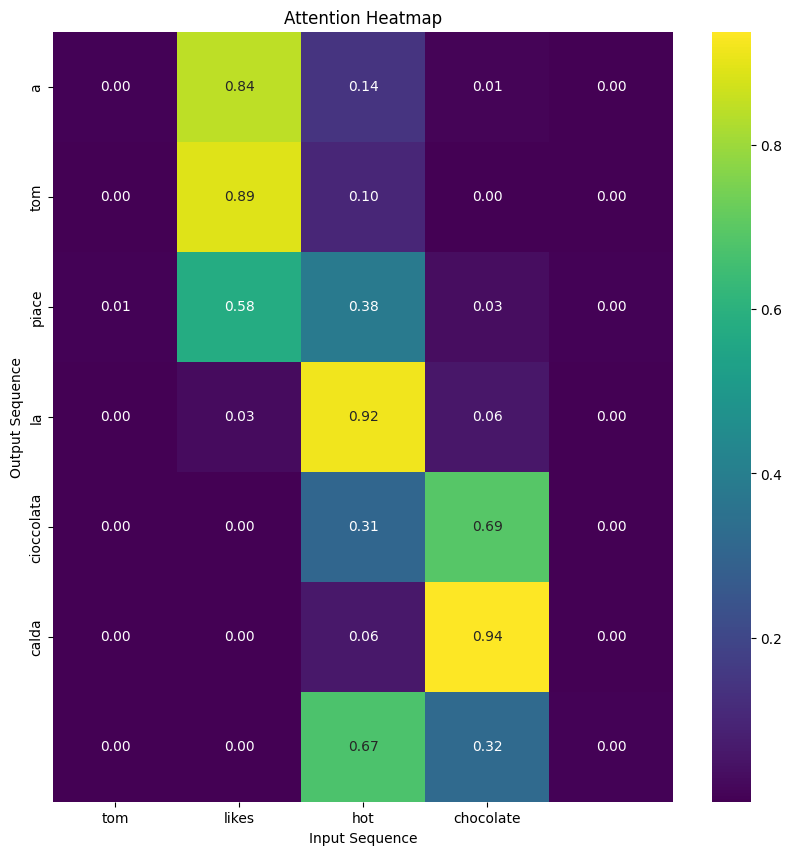

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_attention(attention_matrix, input_sentence, output_sentence):
    attention_matrix = attention_matrix.squeeze(1)

    fig, ax = plt.subplots(figsize=(10,10))
    attention_heatmap = sns.heatmap(attention_matrix, annot=True, ax=ax, cmap="viridis", fmt=".2f",
                                    xticklabels=input_sentence, yticklabels=output_sentence)
    plt.xlabel('Input Sequence')
    plt.ylabel('Output Sequence')
    plt.title('Attention Heatmap')
    plt.show()

attention_matrix = np.array(decoder.attention_matrix)
plot_attention(attention_matrix, tokenize(sentence), tokenize(translated_sentence))